### USING THE BEST LSTM MODEL DEVELOPED TRANSLATING INTO ENGLISH TO TRANSLATE INTO SPANSIH

### Import Required Libraries

In [1]:
import string
import re
from numpy import array, argmax, random, take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Bidirectional, RepeatVector, TimeDistributed, Dropout
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
% matplotlib inline
pd.set_option('display.max_colwidth', 200)

Using TensorFlow backend.


### Read Data

Our data is a text file of English-Spanish sentence pairs. First we will read the file using the function defined below.

In [0]:
# function to read raw text file
def read_text(filename):
    # open the file
    file = open(filename, mode='rt', encoding='utf-8')
    # read all text
    text = file.read()
    file.close()
    return text

Now let's define a function to split the text into English-Spanish pairs separated by '\n' and then split these pairs into English sentences and Spanish sentences.

In [0]:
# split a text into sentences
def to_lines(text):
    sents = text.strip().split('\n')
    sents = [i.split('\t') for i in sents]
    return sents

In [4]:
from google.colab import drive
drive.mount('/content/drive')

# Navigate to code directory
%cd /content/drive/My Drive/NLP_Julia

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive/NLP_Julia


In [0]:
data = read_text("spa-eng/spa.txt")
spa_eng = to_lines(data)
spa_eng = array(spa_eng)[:,0:2] #NOS QUEDAMOS SOLO CON LAS PRIMERAS COLUMNAS QUE TIENEN LA INFORMACION

The actual data contains over 150,000 sentence-pairs. However, we will use the first 80,000 sentence pairs only to reduce the training time of the model. You can change this number as per you system computation power.

In [0]:
#PARA ENTRENAR EL PRIMER MODELO VOY A USARLAS TODAS ASI QUE COMENTO ESTA LINEA
spa_eng = spa_eng[:80000,:]

### Text Pre-Processing

#### Text Cleaning

Let's take a look at our data, then we will decide which pre-processing steps to adopt.

In [0]:
spa_eng

array([['Go.', 'Ve.'],
       ['Go.', 'Vete.'],
       ['Go.', 'Vaya.'],
       ...,
       ['Suddenly, all the lights went out.',
        'De repente se apagaron todas las luces.'],
       ['Suddenly, the dog started barking.',
        'De repente el perro empezó a ladrar.'],
       ['Swimming in the pond is dangerous.',
        'Es peligroso nadar en la laguna.']], dtype='<U332')

We will get rid of the punctuation marks, and then convert the text to lower case.

#### *IMPORTANTE QUITAR LA EXCLAMACION HACIA ARRIBA PARA EL ESPAÑOL



In [0]:
# Remove punctuation
spa_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in spa_eng[:,0]]
spa_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in spa_eng[:,1]]

## TAMBIEN QUITAMOS ESTA EXCLAMACION E INTERROGACION QUE LO ANTERIOR NO LO QUITA
spa_eng[:,0] = [s.translate(str.maketrans('', '', '¡')) for s in spa_eng[:,0]]
spa_eng[:,1] = [s.translate(str.maketrans('', '', '¡')) for s in spa_eng[:,1]]
spa_eng[:,0] = [s.translate(str.maketrans('', '', '¿')) for s in spa_eng[:,0]]
spa_eng[:,1] = [s.translate(str.maketrans('', '', '¿')) for s in spa_eng[:,1]]

# convert to lowercase
for i in range(len(spa_eng)):
    spa_eng[i,0] = spa_eng[i,0].lower()
    
    spa_eng[i,1] = spa_eng[i,1].lower()

In [0]:
spa_eng

array([['go', 've'],
       ['go', 'vete'],
       ['go', 'vaya'],
       ...,
       ['suddenly all the lights went out',
        'de repente se apagaron todas las luces'],
       ['suddenly the dog started barking',
        'de repente el perro empezó a ladrar'],
       ['swimming in the pond is dangerous',
        'es peligroso nadar en la laguna']], dtype='<U332')

#### Text to Sequence Conversion

To feed our data in a Seq2Seq model, we will have to convert both the input and the output sentences into integer sequences of fixed length. Before that, let's visualise the length of the sentences. We will capture the lengths of all the sentences in two separate lists for English and Spanish, respectively.

In [0]:
# empty lists
eng_l = []
spa_l = []

# populate the lists with sentence lengths
for i in spa_eng[:,0]:
    eng_l.append(len(i.split()))

for i in spa_eng[:,1]:
    spa_l.append(len(i.split()))

In [9]:
length_df = pd.DataFrame({'eng':eng_l, 'spa':spa_l})
#print(length_df)
print(max(length_df.eng))
print(max(length_df.spa))

10
15


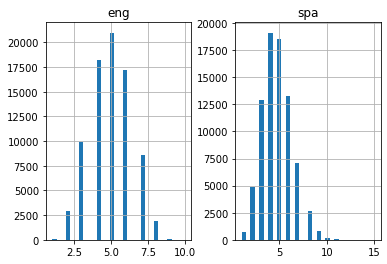

In [10]:
length_df.hist(bins = 30)
plt.show()

The maximum length of the Spanish sentences is 15 and that of the English phrases is 10.


Let's vectorize our text data by using Keras's Tokenizer() class. It will turn our sentences into sequences of integers. Then we will pad those sequences with zeros to make all the sequences of same length.

In [0]:
# function to build a tokenizer
def tokenization(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [12]:
# prepare english tokenizer
eng_tokenizer = tokenization(spa_eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 15
print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 9440


In [13]:
# prepare Spanish tokenizer
spa_tokenizer = tokenization(spa_eng[:, 1])
spa_vocab_size = len(spa_tokenizer.word_index) + 1

spa_length = 15
print('Spanish Vocabulary Size: %d' % spa_vocab_size)

Spanish Vocabulary Size: 18327


In [0]:
#print(spa_tokenizer.word_counts)

Given below is a function to prepare the sequences. It will also perform sequence padding to a maximum sentence length as mentioned above. 

In [0]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
    # integer encode sequences
    seq = tokenizer.texts_to_sequences(lines)
    # pad sequences with 0 values
    seq = pad_sequences(seq, maxlen=length, padding='post')
    print(seq)
    print(len(seq))
    return seq

### Model Building

We will now split the data into train and test set for model training and evaluation, respectively.

In [0]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(spa_eng, test_size=0.2, random_state = 12)

It's time to encode the sentences. We will encode Spanish sentences as the input sequences and English sentences as the target sequences. It will be done for both train and test datasets.

In [17]:
# prepare training data
trainX = encode_sequences(eng_tokenizer, eng_length, train[:, 0])
trainY = encode_sequences(spa_tokenizer, spa_length, train[:, 1])

[[   1  223    2 ...    0    0    0]
 [ 388    5 1608 ...    0    0    0]
 [  12    7   92 ...    0    0    0]
 ...
 [   2  117   10 ...    0    0    0]
 [  55  480  576 ...    0    0    0]
 [  13  165  850 ...    0    0    0]]
64000
[[  10  237    4 ...    0    0    0]
 [  63   16    7 ...    0    0    0]
 [  40    6    4 ...    0    0    0]
 ...
 [  15  280   96 ...    0    0    0]
 [  50  242 1942 ...    0    0    0]
 [  19  129 1537 ...    0    0    0]]
64000


In [19]:
print(trainX.shape)
print(trainY.shape)

(64000, 15)
(64000, 15)


In [18]:
# prepare validation data
testX = encode_sequences(eng_tokenizer, eng_length, test[:, 0])
testY = encode_sequences(spa_tokenizer, spa_length, test[:, 1])

[[   3  350   33 ...    0    0    0]
 [1172   10    0 ...    0    0    0]
 [  57   62   97 ...    0    0    0]
 ...
 [   3   87   29 ...    0    0    0]
 [ 133    1   59 ...    0    0    0]
 [  90  856   24 ...    0    0    0]]
16000
[[   1  917 6947 ...    0    0    0]
 [  26 6110    0 ...    0    0    0]
 [ 724   34  123 ...    0    0    0]
 ...
 [   3    1    2 ...    0    0    0]
 [  10  187  433 ...    0    0    0]
 [7454 3354 2407 ...    0    0    0]]
16000


In [20]:
print(testX.shape)
print(testY.shape)

(16000, 15)
(16000, 15)


Now comes the exciting part! Let us define our Seq2Seq model architecture. We are using an Embedding layer and an LSTM layer as our encoder and another LSTM layer followed by a Dense layer as the decoder.  

In [0]:
# build NMT model (LSTM)
def build_model(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(LSTM(units,return_sequences=True))
    model.add(Dropout(0.1))
    model.add(LSTM(units))
    model.add(RepeatVector(out_timesteps))    
    model.add(LSTM(units, return_sequences=True))
    model.add(Dropout(0.1))
    model.add(Dense(out_vocab, activation='softmax'))
    return model

We are using RMSprop optimizer in this model as it is usually a good choice for recurrent neural networks.

In [22]:
print(spa_vocab_size)
print(eng_vocab_size)
print(spa_length)
print(eng_length)

18327
9440
15
15


In [0]:
model = build_model(eng_vocab_size, spa_vocab_size, eng_length, spa_length, 512)
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

Please note that we have used __'sparse_categorical_crossentropy'__ as the loss function because it allows us to use the target sequence as it is instead of one hot encoded format. One hot encoding the target sequences with such a huge vocabulary might consume our system's entire memory.

It seems we are all set to start training our model. We will train it for 35 epochs and with a batch size of 400. You may change and play these hyperparameters. We will also be using __ModelCheckpoint()__ to save the best model with lowest validation loss. I personally prefer this method over early stopping.

In [24]:
filename = 'modelLSTM_EngtoSpa.h1'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1), 
          epochs=35, batch_size=400, #512 
          validation_split = 0.2,
          callbacks=[checkpoint], verbose=1)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 51200 samples, validate on 12800 samples
Epoch 1/35
51200/51200 [==============================] - 95s 2ms/step - loss: 2.5542 - val_loss: 2.2281

Epoch 00001: val_loss improved from inf to 2.22815, saving model to modelLSTM_EngtoSpa.h1
Epoch 2/35
51200/51200 [==============================] - 93s 2ms/step - loss: 2.1537 - val_loss: 2.1155

Epoch 00002: val_loss improved from 2.22815 to 2.11550, saving model to modelLSTM_EngtoSpa.h1
Epoch 3/35
51200/51200 [==============================] - 93s 2ms/step - loss: 2.0417 - val_loss: 2.0349

Epoch 00003: val_loss improved from 2.11550 to 2.03487, saving model to modelLSTM_EngtoSpa.h1
Epoch 4/35
51200/51200 [==============================] - 93s 2ms/step - loss: 1.9283 - val_loss: 1.9298

Epoch 00004: val_loss improved from 2.03487 to 1.92984, saving model to modelLSTM_EngtoSpa.h1
Epoch 5/35
51200/51200 [==============================] - 93s 2ms/step - loss: 1.8112 - val_loss: 1.8186

Epoch 00005: val_loss improved from 1.92984 to 1

Let's compare the training loss and the validation loss.

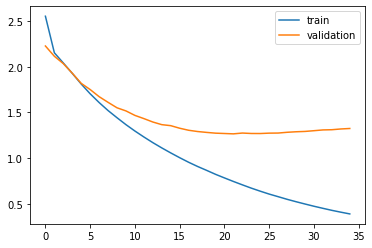

In [25]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

### Make Predictions

Let's load the saved model to make predictions.

In [26]:
model = load_model('modelLSTM_EngtoSpa.h1')
preds = model.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [0]:
def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word
    return None

In [0]:
# convert predictions into text (Spanish)
preds_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], spa_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], spa_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
             
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t)            
        
    preds_text.append(' '.join(temp))

In [0]:
pred_df = pd.DataFrame({'English':  test[:,0], 'actual traduction' : test[:,1], 'predicted' : preds_text})
pd.set_option('display.max_colwidth', 200)

In [30]:
pred_df.head(15)

,English,actual traduction,predicted
0,tom felt his knees tremble,tom sentía temblar sus rodillas,tom se sus su sus
1,thatll do,eso valdrá,eso lo
2,ill come back later,volveré más tarde,volveré más tarde
3,i am exhausted,estoy reventado,estoy exhausto
4,dont do it,no lo hagáis,no lo hagas
5,my upper right wisdom tooth hurts,me duele la muela del juicio superior derecha,mi me se a de
6,youve already forgotten,ya lo has olvidado,ya has
7,why are you wearing a sweater,por qué llevas un suéter,por qué lleva un suéter
8,dont underestimate me,no me subestimes,no me
9,it was my idea,eso fue idea mía,fue mi idea


In [31]:
pred_df.sample(15)

,English,actual traduction,predicted
4263,almost everyone failed,casi todos suspendieron,todos
5601,i gave him my phone number,le di mi número de teléfono,le di mi número
3335,lets go to my place,vamos a ir a mi casa,vayamos a mi
14044,older people often fear change,la gente mayor suele temer el cambio,la mayoría de se les que
8602,he enjoys playing tennis,le gusta jugar al tenis,él gusta jugar a jugar tenis
14483,watch out,abusado,mira
15800,hes as strong as a horse,él es tan fuerte como un toro,él tan como un
11117,she needs you,ella te necesita,ella necesita
1941,what are you preparing,qué estás preparando,qué estás
1451,you should know yourself,deberías conocerte,deberías saberlo


In this notebook we do the translation from english to spanish. The error 1.26519 is higher than the error we got with the same model when translating to english 1.05608. Nevertheless, it does a pretty good job in the actual translation of sentences. For examplein line 14483 it translates "watch out" for "mira" which is a better translation than the actual one "abusado". Most of the sentences are translated well enough to be understood so we are satisfied with the results.